In [1]:
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import math
import numbers
import random
import torch
import torchvision.transforms as transf
from skimage.transform import rescale, resize, downscale_local_mean
import torch.nn.functional as F
from skimage.transform import resize, rotate
from torchvision.transforms.transforms import RandomCrop as RandomCr
#import F.functional_tensor as F_t
from torchvision.transforms import functional_tensor as F_t
import torchvision.transforms.functional as TVF
import cv2
#from PIL import Image, ImageOps
import numpy as np


In [2]:
class MaskToTensor(object):
    def __call__(self, img):
        #return torch.from_numpy(img)
        image = torch.from_numpy(np.array(img)).long() #long returns torch.int64 instead of torch.uint8
        return image

In [3]:
MaskToTensor() 

In [4]:
img_npy = '/mnt/qb/baumgartner/cschmidt77_data/acdc/slices/train/pat_7_diag_2_frame_01_slice_5.npy'

In [5]:
mask_npy = '/mnt/qb/baumgartner/cschmidt77_data/acdc/gt/train/pat_7_diag_2_frame_01_slice_5.npy'

In [6]:
img, mask = np.load(img_npy), np.load(mask_npy)

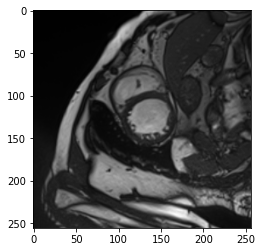

In [7]:
plt.imshow(img, cmap='gray')

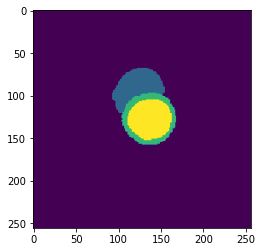

In [8]:
plt.imshow(mask)


In [10]:
mask = torch.from_numpy(mask).long()

In [11]:
mask.shape


torch.Size([256, 256])

In [9]:
img_t = torch.from_numpy(img)

In [10]:
img_t.shape

torch.Size([256, 256])

In [11]:
img_t

tensor([[-1.1271, -1.1271, -1.1271,  ..., -0.5773, -0.6988, -0.8139],
        [-1.1271, -1.1271, -1.1271,  ..., -0.7133, -0.7362, -0.7304],
        [-1.1271, -1.1271, -1.1271,  ..., -0.5635, -0.5470, -0.5409],
        ...,
        [-0.7338, -0.7522, -0.7358,  ..., -0.8580, -0.8522, -0.8393],
        [-0.7621, -0.7508, -0.7507,  ..., -0.8546, -0.8440, -0.8352],
        [-0.7622, -0.7608, -0.7706,  ..., -0.8609, -0.8524, -0.8492]])

In [12]:
hflipped = TVF.vflip(img_t)

In [13]:
hflipped.dtype

torch.float32

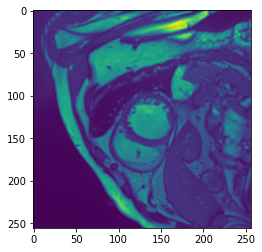

In [14]:
plt.imshow(hflipped)

In [15]:
zero_pad = nn.ZeroPad2d(10)

In [16]:
img_t.min().item()

-1.1593135595321655

In [17]:
min_pad = nn.ConstantPad2d(10, img_t.min().item()
)

In [18]:
padded = min_pad(img_t)

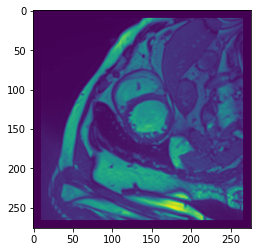

In [19]:
plt.imshow(padded)

In [22]:
w, h = img.shape

In [23]:
size = [160, 160]

In [24]:
th, tw = size

In [27]:
resized = resize(padded, (tw, th), anti_aliasing=False)

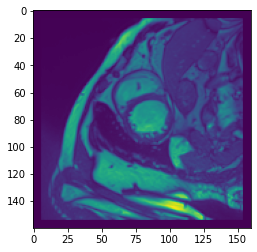

In [28]:
plt.imshow(resized)

In [29]:
x1 = random.randint(0, w - tw)
print("x1: ", x1)
y1 = random.randint(0, h - th)
print("y1: ", y1)
print("tw: ", tw)
print("th: ", th)

x1:  70
y1:  52
tw:  160
th:  160


In [30]:
padded.shape

torch.Size([276, 276])

In [141]:
((x1, x1+tw), (y1, y1+th))

((155, 261), (90, 250))

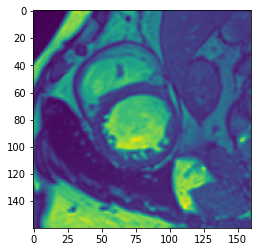

In [32]:
dliced = padded[y1:y1+th, x1:x1+tw]
plt.imshow(dliced)

In [148]:
sliced = img[x1:x1+tw, y1:y1+th]
sliced.shape

torch.Size([106, 160])

In [34]:
w,h = img.shape

In [35]:
tw = 220
th = 220

In [36]:
mask_resized = resize(mask, (tw, th), anti_aliasing=True)

In [37]:
image_resized = resize(img_t, (tw, th), anti_aliasing=True)

In [38]:
torch.from_numpy(image_resized).shape

torch.Size([220, 220])

In [39]:
x1 = random.randint(0, w - tw)
y1 = random.randint(0, h - th)

In [40]:
from skimage import io

/home/carina/.local/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [41]:
img_arr = np.array(img).shape


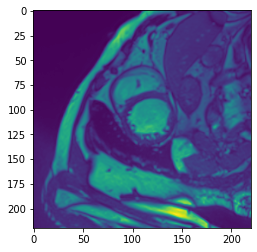

In [42]:
plt.imshow(image_resized)


In [91]:
class RandomCrop(object):
    def __init__(self, size, padding=0):
        if isinstance(size, numbers.Number):
            print("RANDOMCROP size before random crop: ", size)
            self.size = (int(size), int(size)) ##TODO check how this works!! size is list [196, 196]
        else:
            print("RANDOMCROP size before random crop: ", size)
            self.size = size
        self.padding = padding

    def __call__(self, img, mask):
        if self.padding > 0:
            pad_img = nn.ConstantPad2d(self.padding, img.min().item()) #padding with the smallest value in tensor (not 0!)
            pad_mask = nn.ConstantPad2d(self.padding, mask.min().item())
            img = pad_img(img)
            mask = pad_mask(mask)
          
        assert img.shape == mask.shape
        w, h = img.shape
        th, tw = self.size
        if w == tw and h == th:
            return img, mask
        if w < tw or h < th:
            img_resized, mask_resized = resize(img, (tw, th), anti_aliasing=True), resize(mask, (tw, th), anti_aliasing=True)
            img, mask = torch.from_numpy(img_resized), torch.from_numpy(mask_resized)
            return img, mask

        x1 = random.randint(0, w - tw)
        y1 = random.randint(0, h - th)
        #img_cropped = crop(img, ((x1, x1+tw), (y1, y1+th)), copy=False)
        #mask_cropped = crop(mask, ((x1, x1+tw), (y1, y1+th)), copy=False)
        img = img[x1:x1+tw, y1:y1+th]
        mask = mask[x1:x1+tw, y1:y1+th] #slices torch tensor
        #img, mask = torch.from_numpy(img_cropped), torch.from_numpy(mask_cropped)

        return img, mask

In [48]:
class CenterCrop(object):
    def __init__(self, size):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size

    def __call__(self, img, mask):

        assert img.shape == mask.shape
        w, h = img.shape
        th, tw = self.size
        if w == tw and h == th:
            return img, mask
        if w < tw or h < th:
            img_resized, mask_resized = resize(img, (tw, th), anti_aliasing=True), resize(mask, (tw, th), anti_aliasing=True)
            img, mask = torch.from_numpy(img_resized), torch.from_numpy(mask_resized)
            return img, mask
            #return img.resize((tw, th), Image.BILINEAR), mask.resize((tw, th), Image.NEAREST)

        i = int(round((h - th) / 2.))
        j = int(round((w - tw) / 2.))

        #img_cropped = crop(img, ((i, i+tw), (j, j+th)), copy=False)
        #mask_cropped = crop(mask, ((i, i+tw), (j, j+th)), copy=False)
        #img, mask = torch.from_numpy(img_cropped), torch.from_numpy(mask_cropped)
        img = img[i:i+tw, j:j+th]
        mask = mask[i:i+tw, j:j+th]
        return img, mask

In [58]:
image_resized = torch.from_numpy(image_resized)
mask_resized = torch.from_numpy(mask_resized)

In [116]:
random_rc = RandomCrop((190,190), padding=1)
r_croppi = random_rc(image_resized, mask_resized)

RANDOMCROP size before random crop:  (190, 190)


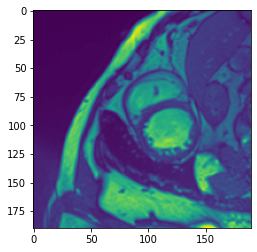

In [117]:
plt.imshow(r_croppi[0])

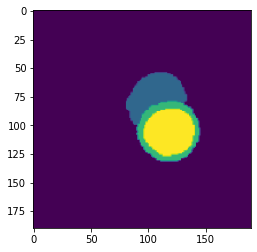

In [118]:
plt.imshow(r_croppi[1])

In [63]:
center_c = CenterCrop((150,150))
c_croppi = center_c(image_resized, mask_resized)

In [122]:
mask_resized.dtype

torch.float64

In [124]:
ml = mask_resized.to(torch.long)
print(ml.dtype)

torch.int64


In [72]:
c_croppi[0].min()

tensor(-1.1047)

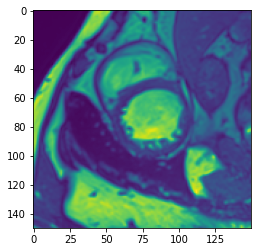

In [64]:
plt.imshow(c_croppi[0])

In [67]:
class RandomCropRegion(object):
    def __init__(self, size, padding=0, region_size=(128, 128)):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size
        self.padding = padding
        self.region_size = region_size

    def __call__(self, img, mask, region):
        if self.padding > 0:
            #img = ImageOps.expand(img, border=self.padding, fill=0)
            #mask = ImageOps.expand(mask, border=self.padding, fill=0)
            pad_img = nn.ConstantPad2d(self.padding, img.min().item()) #padding with the smallest value in tensor (not 0!)
            pad_mask = nn.ConstantPad2d(self.padding, mask.min().item())
            img = pad_img(img)
            mask = pad_mask(mask)
        #img = F.pad(img, pad = (self.padding, self.padding, self.padding, self.padding), mode='constant', value=0)
        assert img.shape == mask.shape
        w, h = img.shape #img.size
        th, tw = self.size
        if w == tw and h == th:
            return img, mask
        if w < tw or h < th:
            img_resized, mask_resized = resize(img, (tw, th), anti_aliasing=True), resize(mask, (tw, th), anti_aliasing=True)
            img, mask = torch.from_numpy(img_resized), torch.from_numpy(mask_resized)
            return img, mask#img.resize((tw, th), torch.nn.Upsample('Bilinear')), mask.resize((tw, th), torch.nn.Upsample('nearest'))

        # Get upper left corner of the crop
        y1 = random.randint(max(0, region[1] + self.region_size[1] // 2 - th),
                            min(region[1] + self.region_size[1] // 2, h - th))
        x1 = random.randint(max(0, region[0] + self.region_size[0] // 2 - tw),
                            min(region[0] + self.region_size[0] // 2, w - tw))
        
        #img_cropped = crop(img, ((x1, x1+tw), (y1, y1+th)), copy=False)
        #mask_cropped = crop(mask, ((x1, x1+tw), (y1, y1+th)), copy=False)
        #img, mask = torch.from_numpy(img_cropped), torch.from_numpy(mask_cropped)
        img = img[x1:x1+tw, y1:y1+th]
        mask = mask[x1:x1+tw, y1:y1+th]
        
        return img, mask

In [69]:
random_cr = RandomCropRegion((180,180), padding=1, region_size=(128, 128))
rcr_croppi = random_rc(image_resized, mask_resized)

In [73]:
rcr_croppi[0]

tensor([[-1.1080, -1.1056, -1.1061,  ..., -0.2286, -0.4344, -0.4829],
        [-1.1062, -1.1047, -1.1047,  ..., -0.2906, -0.4691, -0.3921],
        [-1.1047, -1.1047, -1.1047,  ..., -0.3234, -0.4990, -0.2923],
        ...,
        [-0.5740, -0.5782, -0.5942,  ..., -0.8484, -0.8578, -0.8735],
        [-0.6015, -0.5993, -0.6035,  ..., -0.8608, -0.8642, -0.8630],
        [-0.6013, -0.5849, -0.5699,  ..., -0.8342, -0.8465, -0.8572]])

In [74]:
class CropRegion(object):
    '''
    Crops the image so that the region is always contained inside
    '''

    def __init__(self, size, padding=0, region_size=128):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size
        self.padding = padding
        self.region_size = 128

    def __call__(self, img, mask, region):
        if self.padding > 0:
            #img = ImageOps.expand(img, border=self.padding, fill=0)
            #mask = ImageOps.expand(mask, border=self.padding, fill=0)
            pad_img = nn.ConstantPad2d(self.padding, img.min().item()) #padding with the smallest value in tensor (not 0!)
            pad_mask = nn.ConstantPad2d(self.padding, mask.min().item())
            img = pad_img(img)
            mask = pad_mask(mask)
        #img = F.pad(img, padding = (self.padding, self.padding, self.padding, self.padding), mode='constant', value=0)
        assert img.shape == mask.shape#assert img.size == mask.size
        w, h = img.shape #img.size
        th, tw = self.size
        if w == tw and h == th:
            return img, mask
        if w < tw or h < th:
            img_resized, mask_resized = resize(img, (tw, th), anti_aliasing=True), resize(mask, (tw, th), anti_aliasing=True)
            img, mask = torch.from_numpy(img_resized), torch.from_numpy(mask_resized)
            return img, mask
            #return img.resize((tw, th), Image.BILINEAR), mask.resize((tw, th), Image.NEAREST)
            #return img.resize((tw, th), torch.nn.Upsample('Bilinear')), mask.resize((tw, th), torch.nn.Upsample('nearest'))
        # Get upper left corner of the crop
        y1 = random.randint(max(0, region[1] + self.region_size - th), min(region[1], h - th))
        x1 = random.randint(max(0, region[0] + self.region_size - tw), min(region[0], w - tw))

        #img_cropped = crop(img, ((x1, x1+tw), (y1, y1+th)), copy=False)
        #mask_cropped = crop(mask, ((x1, x1+tw), (y1, y1+th)), copy=False)
        #img, mask = torch.from_numpy(img_cropped), torch.from_numpy(mask_cropped)
        img = img[x1:x1+tw, y1:y1+th]
        mask = mask[x1:x1+tw, y1:y1+th]
        return img, mask

In [76]:
cr = CropRegion((180,180), padding=1, region_size=(128, 128))
cr_croppi = cr(image_resized, mask_resized, [80,90])

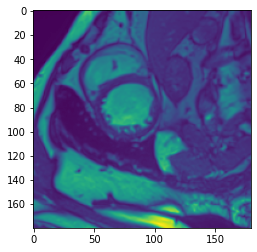

In [77]:
plt.imshow(cr_croppi[0])

In [78]:
class RandomHorizontallyFlip(object):
    def __call__(self, img, mask, region=None):
        if random.random() < 0.5:
            #return img.transpose(Image.FLIP_LEFT_RIGHT), mask.transpose(Image.FLIP_LEFT_RIGHT)
            #print('img.shape: ', type(img))
            return TVF.hflip(img), TVF.hflip(mask)
        return img, mask

In [80]:
rhf = RandomHorizontallyFlip()
flippe = rhf(image_resized, mask_resized)

In [81]:
flippe

(tensor([[-1.1271, -1.1271, -1.1271,  ..., -0.5525, -0.6740, -0.7984],
         [-1.1271, -1.1271, -1.1271,  ..., -0.6660, -0.6865, -0.6844],
         [-1.1271, -1.1271, -1.1271,  ..., -0.5122, -0.5338, -0.5626],
         ...,
         [-0.7354, -0.7468, -0.7173,  ..., -0.8523, -0.8487, -0.8366],
         [-0.7548, -0.7501, -0.7396,  ..., -0.8602, -0.8483, -0.8370],
         [-0.7620, -0.7622, -0.7617,  ..., -0.8669, -0.8538, -0.8484]]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64))

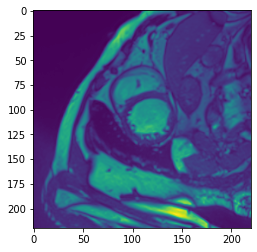

In [85]:
plt.imshow(flippe[0])

In [287]:
class FreeScale(object):
    def __init__(self, size):
        self.size = tuple(reversed(size))  # size: (h, w)

    def __call__(self, img, mask):
        assert img.shape == mask.shape #assert img.size == mask.size
        #return img.resize(self.size, Image.BILINEAR), mask.resize(self.size, Image.NEAREST)
        img_resized, mask_resized = resize(img, self.size, anti_aliasing=True), resize(mask, self.size, anti_aliasing=True)
        img, mask = torch.from_numpy(img_resized), torch.from_numpy(mask_resized)
        return img, mask

In [305]:
fs = FreeScale([500,500])
scaled = fs(img, mask)

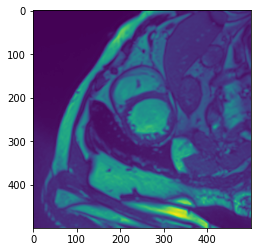

In [306]:
plt.imshow(scaled[0])

In [365]:
class Scale(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, img, mask, region=None):
        assert img.shape == mask.shape #assert img.size == mask.size
        w, h = img.shape #img.size
        if (w >= h and w == self.size) or (h >= w and h == self.size):
            return img, mask
        if w > h:
            ow = self.size
            oh = int(self.size * h / w)
            #return img.resize((ow, oh), Image.BILINEAR), mask.resize((ow, oh), Image.NEAREST)
            img_resized, mask_resized = resize(img, (ow, oh), anti_aliasing=True), resize(mask, (ow, oh), anti_aliasing=True)
            img, mask = torch.from_numpy(img_resized), torch.from_numpy(mask_resized)
            return img, mask
        else:
            oh = self.size
            ow = int(self.size * w / h)
            #return img.resize((ow, oh), Image.BILINEAR), mask.resize((ow, oh), Image.NEAREST)
            img_resized, mask_resized = resize(img, (ow, oh), anti_aliasing=True), resize(mask, (ow, oh), anti_aliasing=True)
            img, mask = torch.from_numpy(img_resized), torch.from_numpy(mask_resized)
            return img, mask

In [366]:
scale = Scale(80)
sc = scale(img, mask)

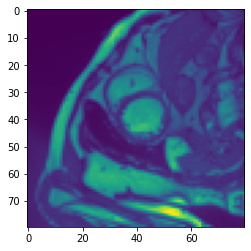

In [367]:
plt.imshow(sc[0])

In [323]:
class RandomVerticalFlip(object):
    def __call__(self, img):
        if random.random() < 0.5:
            #return img.transpose(Image.FLIP_LEFT_RIGHT), mask.transpose(Image.FLIP_LEFT_RIGHT)
            #print('img.shape: ', type(img))
            return TVF.vflip(img)
        return img

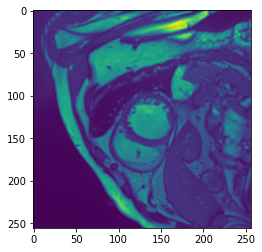

In [326]:
rvf = RandomVerticalFlip()
rf = rvf(img)
plt.imshow(rf)

In [327]:
class MaskToTensor(object):
    def __call__(self, img):
        #return torch.from_numpy(img)
        if type(img) != torch.Tensor:
            return torch.from_numpy(np.array(img)).long() #long returns torch.int64 instead of torch.uint8
        else:
            return img

In [86]:
mtt =MaskToTensor()
mtt = mtt(mask)

In [87]:
mtt.shape

torch.Size([256, 256])

In [88]:
img.dtype

torch.float32

In [89]:
class FreeScale(object):
    # #def __init__(self, size, interpolation=Image.BILINEAR):
     def __init__(self, size, interpolation=torch.nn.Bilinear):
        self.size = tuple(reversed(size))  # size: (h, w)
        self.interpolation = interpolation
     def __call__(self, img):
        print(self.size)
        print(self.interpolation)
        ow, oz = self.size
        print(img.shape)
        img = img.numpy()
        img_resized = resize(img, ((ow,oz), self.interpolation), anti_aliasing=True)
        img = torch.from_numpy(img_resized)
        return img


In [90]:
fs = FreeScale(size=[90,90])
fs(img)

(90, 90)
<class 'torch.nn.modules.linear.Bilinear'>
torch.Size([276, 276])


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [369]:
class RandomRotate(object):
    def __init__(self, degree):
        self.degree = degree

    def __call__(self, img, mask):
        rotate_degree = random.random() * 2 * self.degree - self.degree
        #return img.rotate(rotate_degree, Image.BILINEAR), mask.rotate(rotate_degree, Image.NEAREST)
        return rotate(img, rotate_degree), rotate(mask, rotate_degree)

In [372]:
rr = RandomRotate(45)
rr = rr(img, mask)

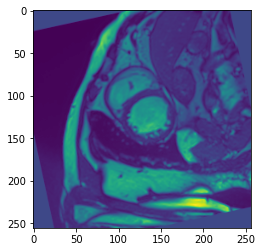

In [377]:
plt.imshow(rr[0])